# Train a deep learning model
In this notebook you will train a deep learning model to classify the descriptions of car components as compliant or non-compliant. 

Each document in the supplied training data set is a short text description of the component as documented by an authorized technician. 
The contents include:
- Manufacture year of the component (e.g. 1985, 2010)
- Condition of the component (poor, fair, good, new)
- Materials used in the component (plastic, carbon fiber, steel, iron)

The compliance regulations dictate:
*Any component manufactured before 1995 or in fair or poor condition or made with plastic or iron is out of compliance.*

For example:
* Manufactured in 1985 made of steel in fair condition -> **Non-compliant**
* Good condition carbon fiber component manufactured in 2010 -> **Compliant**
* Steel component manufactured in 1995 in fair condition -> **Non-Compliant**

The labels present in this data are 0 for compliant, 1 for non-compliant.

The challenge with classifying text data is that deep learning models only undertand vectors (e.g., arrays of numbers) and not text. To encode the car component descriptions as vectors, we use an algorithm from Stanford called [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/). GloVe provides us pre-trained vectors that we can use to convert a string of text into a vector.

In [1]:
import os
import random

import numpy as np
import pandas as pd

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Flatten, Dense

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

Using TensorFlow backend.


# Creating a Deep Learning model from text data
The following cell will guide you through the process of preparing the data and using it to train a model.

### Download the GloVe embeddings to your environment.
Run the following cell to download the embeddings to the `data` folder in your environment. Note: this may take a **few minutes** as the GloVe file is about 340 MB.

In [2]:
def download_glove():
    print("Downloading GloVe embeddings...")
    import urllib.request
    glove_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
                 'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/'
                 'quickstarts/connected-car-data/glove.6B.100d.txt')
    urllib.request.urlretrieve(glove_url, 'glove.6B.100d.txt')
    print("Download complete.")

download_glove()

Download complete.


Next load the data into a Pandas DataFrame and create the training, validation and test data sets by running the following cell.

In [3]:
# Load the car components labeled data
print("Loading car components data...")
data_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
            'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/'
            'quickstarts/connected-car-data/connected-car_components.csv')
car_components_df = pd.read_csv(data_url)
components = car_components_df["text"].tolist()
labels = car_components_df["label"].tolist()
print("Loading car components data completed.")

# split data 60% for trianing, 20% for validation, 20% for test
print("Splitting data...")
train, validate, test = np.split(car_components_df.sample(frac=1), [int(.6*len(car_components_df)), int(.8*len(car_components_df))])
print(train.shape)
print(test.shape)
print(validate.shape)

Loading car components data...
Loading car components data completed.
Splitting data...
(60000, 2)
(20000, 2)
(20000, 2)


In the following cell, you use the Tokenizer from Keras to "learn" a vocabulary from the entire car components text. Then the data (both the text and the compliance labels) is split into three subsets, one that will be used for training the deep learning model, one that will be used during training batches to tune the model weights and one that will be used after the model is trained to evaluate how it performs on data the model has never seen. 

Run the following cell.

In [4]:
# use the Tokenizer from Keras to "learn" a vocabulary from the entire car components text
print("Tokenizing data...")

maxlen = 100                                           
training_samples = 90000                                 
validation_samples = 5000    
max_words = 10000      

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(components)
sequences = tokenizer.texts_to_sequences(components)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])                     
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]
print("Tokenizing data complete.")

Tokenizing data...
Found 65 unique tokens.
Shape of data tensor: (100000, 100)
Shape of label tensor: (100000,)
Tokenizing data complete.


Now take a look at how the text was encoded as an array in the above. Run the following cell to take a peek.

Each text vector will be of fixed length 100 since we defined maxlen to be 100 above. The following text: "manufactured in 1971 made of carbon fiber in good condition" has 10 words, and each word is represented by an integer value as encoded by the keras.preprocessing.text.Tokenizer. For example, the word "manufactured" is represented by the integer "3". Finally, the text vector is prepadded with zeros to fix the vector length to be 100.

In [5]:
print("The text '{text}' is represented as the vector '{data}'".format(text=components[indices[0]], data=x_train[0]))

The text 'manufactured in 1998 made of steel in new condition' is represented as the vector '[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  1 17 10 11
  9  1  7  2]'


Next, you will apply the vectors provided by GloVe to create a word embedding matrix. This matrix will be used shortly to set the model wights of the first layer of the deep neural network. 

Run the following cell.

In [6]:
# apply the vectors provided by GloVe to create a word embedding matrix
print("Applying GloVe vectors...")
glove_dir =  './'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector    
print("Applying GloVe vectors completed.")

Applying GloVe vectors...
Found 400000 word vectors.
Applying GloVe vectors completed.


In the next cell, you will use Keras to define the structure of the deep neural network. The network graph you build in this case has four layers. 

Run the following cell to structure the network and view a summary description of it.

In [7]:
# use Keras to define the structure of the deep neural network   
print("Creating model structure...")

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Creating model structure...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Rather than train model from scratch on this car components text, you can instead use the embedding matrix derived from GloVe. In effect this boosts the model's understanding of text, because the GloVe vectors was trained against a large corpus of text in Wikipedia. 

Run the following cell to fix the weights for the first layer to those provided by the embedding matrix.

In [8]:
# fix the weights for the first layer to those provided by the embedding matrix
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Now you are ready to train the model.

Run the following cell to train the model. This will take **a few minutes** on a CPU cluster.

In [9]:
print("Training model...")
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10, 
                    batch_size=32,
                    validation_data=(x_val, y_val))
print("Training model completed.")

print("Saving model files...")
# create a ./outputs/model folder in the compute target
# files saved in the "./outputs" folder are automatically uploaded into run history
os.makedirs('./outputs/model', exist_ok=True)
# save model
model.save('./outputs/model/model.h5')
print("model saved in ./outputs/model folder")
print("Saving model files completed.")

Training model...
Train on 90000 samples, validate on 5000 samples
Epoch 1/10
90000/90000 [==============================] - 11s 120us/step - loss: 0.0463 - acc: 0.9853 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2/10
90000/90000 [==============================] - 9s 104us/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0053 - val_acc: 0.9968
Epoch 3/10
90000/90000 [==============================] - 9s 101us/step - loss: 8.7385e-04 - acc: 0.9997 - val_loss: 2.5889e-06 - val_acc: 1.0000
Epoch 4/10
90000/90000 [==============================] - 9s 102us/step - loss: 4.1787e-04 - acc: 0.9998 - val_loss: 1.7171e-06 - val_acc: 1.0000
Epoch 5/10
90000/90000 [==============================] - 9s 101us/step - loss: 1.8479e-04 - acc: 0.9999 - val_loss: 1.9863e-08 - val_acc: 1.0000
Epoch 6/10
90000/90000 [==============================] - 9s 103us/step - loss: 9.2926e-07 - acc: 1.0000 - val_loss: 3.2009e-09 - val_acc: 1.0000
Epoch 7/10
90000/90000 [==============================] - 9s 102us/step 

Take a look to see how the model training went. If curves for training accuracy and validation accuracy come together, you are in good shape!

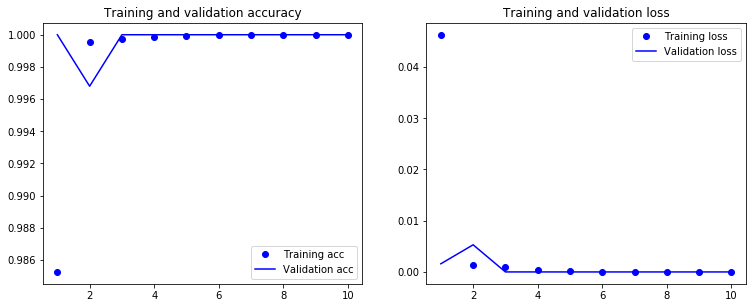

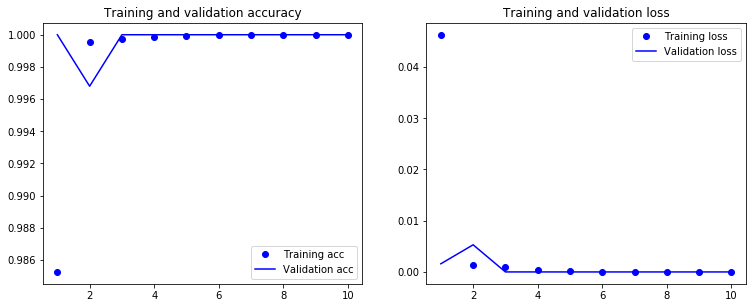

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(ncols=2, figsize=(12.6, 4.8))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()

display(fig)

## Re-load the model from disk
Run the following cell to simulate loading the saved model from disk (as you might do in subsequent scoring sessions).

In [11]:
model = load_model('./outputs/model/model.h5')
print("Model loaded from disk.")
print(model.summary())

Model loaded from disk.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________
None


## Evaluate the model on test data

You can also evaluate how accurately the model performs against data it has not seen. Run the following cell to load the test data that was not used in either training or evaluating the model.

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the car components labeled data
car_components_df = pd.read_csv(data_url)
components = car_components_df["text"].tolist()
labels = car_components_df["label"].tolist()

maxlen = 100                                           
training_samples = 90000                                 
validation_samples = 5000    
max_words = 10000      

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(components)
sequences = tokenizer.texts_to_sequences(components)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])                     
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

Found 65 unique tokens.
Shape of data tensor: (100000, 100)
Shape of label tensor: (100000,)


## Evaluate the model's performance
Run the following cell to observe how the model performs against the test data set.

In [13]:
print('Model evaluation will print the following metrics: ', model.metrics_names)
evaluation_metrics = model.evaluate(x_test, y_test)
print(evaluation_metrics)

Model evaluation will print the following metrics:  ['loss', 'acc']
5000/5000 [==============================] - 0s 40us/step
[8.419850516389049e-10, 1.0]
